In [28]:
# import libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import numpy as np
from scipy import stats
from scipy.stats import wasserstein_distance
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

In [3]:
# function to extract image metadata
def get_image_metadata(image):
    # get width and height of image
    with Image.open(image) as img:
        width, height = img.size

    # calculate image ratio and area
    ratio = width / height
    area = width * height

    # print the metadata
    print(f"image width: {width}")
    print(f"image height: {height}")
    print(f"image ratio: {ratio}")
    print(f"image area: {area}")

#### Image metadata

#### AE Outlier Score

In [7]:
# step 1: load cifar-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform)
test_dataset = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
# step 2: define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 512, 4, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4 * 4 * 512, encoding_dim)
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 4 * 4 * 128),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 256, 4, stride = 2, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 64, 4, stride = 2, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride = 2, padding = 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
# step 3: train the autoencoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoding_dim = 128
num_epochs = 20
learning_rate = 1e-3

model = Autoencoder(encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    model.train()
    for data, _ in train_loader:
        data = data.to(device)
        outputs = model(data)
        loss = criterion(outputs, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'epoch [{epoch + 1}/{num_epochs}], loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.0088
Epoch [2/20], Loss: 0.0061
Epoch [3/20], Loss: 0.0049
Epoch [4/20], Loss: 0.0053
Epoch [5/20], Loss: 0.0052
Epoch [6/20], Loss: 0.0044
Epoch [7/20], Loss: 0.0049
Epoch [8/20], Loss: 0.0044
Epoch [9/20], Loss: 0.0042
Epoch [10/20], Loss: 0.0047
Epoch [11/20], Loss: 0.0049
Epoch [12/20], Loss: 0.0042
Epoch [13/20], Loss: 0.0044
Epoch [14/20], Loss: 0.0037
Epoch [15/20], Loss: 0.0041
Epoch [16/20], Loss: 0.0051
Epoch [17/20], Loss: 0.0032
Epoch [18/20], Loss: 0.0033
Epoch [19/20], Loss: 0.0037
Epoch [20/20], Loss: 0.0044


In [16]:
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=8192, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=2048, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(128, 4, 4))
    (2): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
)


0.010008323704823852
number of outliers detected: 308


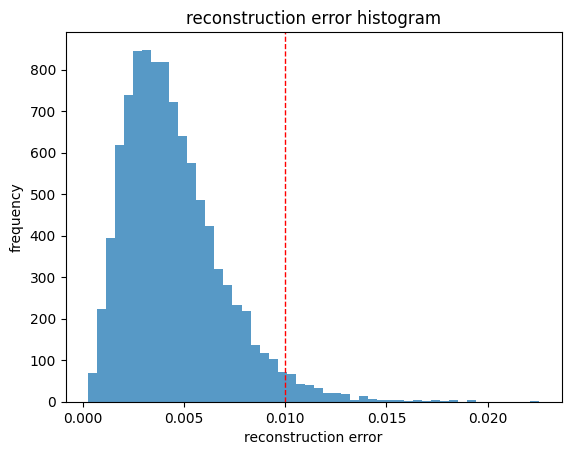

In [15]:
# step 4: calculate outlier score
def calculate_outlier_scores(model, data_loader):
    model.eval()
    scores = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            outputs = model(data)
            loss = nn.functional.mse_loss(outputs, data, reduction = 'none')
            loss = loss.view(loss.size(0), -1).mean(dim = 1)
            scores.extend(loss.cpu().numpy())
    return np.array(scores)

test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

# calculate reconstruction error on the training set
train_reconstruction_error = calculate_outlier_scores(model, train_loader)

# determine a threshold for outlier
threshold = np.mean(train_reconstruction_error) + 3 * np.std(train_reconstruction_error)

# calculate reconstruction error on the test set
test_reconstruction_errors = calculate_outlier_scores(model, test_loader)

# identify outlier
outliers = test_reconstruction_errors > threshold

# print outlier
print("number of outliers detected:", np.sum(outliers))

# plot reconstruction error histogram
plt.hist(test_reconstruction_errors, bins = 50, alpha = 0.75)
plt.axvline(threshold, color = 'r', linestyle = 'dashed', linewidth = 1)
plt.xlabel('reconstruction error')
plt.ylabel('frequency')
plt.title('reconstruction error histogram')
plt.show()

#### KS Drift

#### Data Drift

Wasserstein`s Distance

In [31]:
# 1. load a pre-trained model
model = resnet50(weights = ResNet50_Weights.IMAGENET1K_V2)

# remove the final fully connected layer
model = nn.Sequential(*list(model.children())[:-1])
model.eval()

# define the image transformation
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    ),
])

def extract_features(img_path):
    img = Image.open(img_path).convert('RGB')
    img = preprocess(img)

    # add batch dimension
    img = img.unsqueeze(0)

    with torch.no_grad():
        features = model(img)

    return features.flatten().numpy()

# 2. extract features from images
def compute_feature_distribution(image_paths):
    features_list = [extract_features(img_path) for img_path in image_paths]

    return np.array(features_list)

data_path =  Path('../../../dataset/ram_module')
image_path = data_path / 'image'

coco_data_path =  Path('../../../dataset/coco8-seg')
coco_training_image_path = coco_data_path / 'train/images'
coco_validation_image_path = coco_data_path / 'valid/images'

# collect all image paths
image_paths = [os.path.join(dirpath, filename) for dirpath, dirnames, filenames in os.walk(image_path) for filename in filenames]
coco_training_image_path = [os.path.join(dirpath, filename) for dirpath, dirnames, filenames in os.walk(coco_training_image_path) for filename in filenames]
coco_validation_image_path = [os.path.join(dirpath, filename) for dirpath, dirnames, filenames in os.walk(coco_validation_image_path) for filename in filenames]

# split the data into training and validation sets
# 50% training, 50% validation
train_image_paths, validation_image_paths = train_test_split(image_paths, test_size = 0.5, random_state = 42)

# extract features
train_features = compute_feature_distribution(train_image_paths)
validation_features = compute_feature_distribution(validation_image_paths)
coco_training_features = compute_feature_distribution(coco_training_image_path)
coco_validation_features = compute_feature_distribution(coco_validation_image_path)

# 3. calculate wasserstein`s distance
# flatten the feature arrays
train_features_flattened = train_features.flatten()
validation_features_flattened = validation_features.flatten()
coco_training_features_flattened = coco_training_features.flatten()
coco_validation_features_flattened = coco_validation_features.flatten()

# calculate wasserstein's distance
distance = wasserstein_distance(train_features_flattened, coco_validation_features_flattened)

print("wasserstein distance: ", distance)

# 4. set threshold
threshold = 0.1

if distance > threshold:
    print("feature distributions are significantly different")
else:
    print("feature distributions are similar")

wasserstein distance:  0.009581090411415048
feature distributions are similar


Kullback — Leibler divergence (KL divergence)

Population Stability Index (PSI)

#### Concept Drift

#### Domain Shift

#### Prediction Drift

#### Upstream Drift